In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import requests
import datetime

from datetime import timedelta, date
import time
import os
import numbers

import warnings
warnings.filterwarnings('ignore')

In [2]:
import scenario_generator.curated as curated
import scenario_generator.mcmc_forecast as mcmc
import scenario_generator.utils as u

from mechafil.sim import run_simple_sim
from mechafil.data import get_historical_network_stats, get_sector_expiration_stats, \
    query_starboard_sector_expirations, get_cum_capped_qa_power
from mechafil.power import forecast_power_stats, build_full_power_stats_df
from mechafil.vesting import compute_vesting_trajectory_df
from mechafil.minting import compute_minting_trajectory_df, \
    network_time, cum_baseline_reward
from mechafil.supply import forecast_circulating_supply_df

## 1. Parameters and other variables

In [3]:
# Data starts in filecoin_daily_stats 2021-03-15
# genesis block was in 2020-08-24
# Main net launch was in 2020-10-15

SIM_START_LAG_DAYS = 10
# set the simulation start date
current_date = datetime.datetime.now().date() - datetime.timedelta(days=SIM_START_LAG_DAYS)
current_day = (current_date - datetime.date(2020, 10, 15)).days

start_date = datetime.date(2021, 3, 15)
start_day = (start_date - datetime.date(2020, 10, 15)).days

# Forecast timeframe
forecast_lenght = int(365*3)
end_day = current_day + forecast_lenght
end_date = current_date + datetime.timedelta(days=forecast_lenght)

print(start_date)
print(current_date)
print(end_date)

2021-03-15
2022-11-25
2025-11-24


## 2. Setup Simulation Runner

In [4]:
_, historical_renewal_rate = u.get_historical_renewal_rate(start_date, current_date)
duration = 365 # sector duration

# handy constants
EIB = 2 ** 60
PIB = 2 ** 50
TIB = 2 ** 40
GIB = 2 ** 30
SECTOR_SIZE = 32 * GIB
EPOCH_PER_DAY = 2880

In [5]:
def clip_all_powers(df_in):
    """
    'onboarded_power', 'cum_onboarded_power',
    'expire_scheduled_power', 'cum_expire_scheduled_power', 'renewed_power',
    'cum_renewed_power', 'total_power', 'power_type', 'total_qa_power_eib'
    """
    df_out = df_in.copy()
    for c in df_out.columns:
        if 'power' in c and c != 'power_type':
            df_out[c] = df_out[c].clip(lower=0)
    return df_out

# add ROI to trajectory
def add_generated_quantities(df:pd.DataFrame)->pd.DataFrame:
    # add ROI to trajectory df
    df['day_pledge_per_QAP'] = SECTOR_SIZE * df['day_locked_pledge'] / (df['day_onboarded_power_QAP'] + df['day_renewed_power_QAP'])
    df['day_rewards_per_sector'] = SECTOR_SIZE * df.day_network_reward / df.network_QAP
#     df['1y_return_per_sector'] = df[['iter','day_rewards_per_sector']].groupby('iter').rolling(duration).sum().shift(-duration+1).values.flatten()
    df['1y_return_per_sector'] = df['day_rewards_per_sector'].rolling(duration).sum().shift(-duration+1).values.flatten()
    df['1y_sector_roi'] = df['1y_return_per_sector'] / df['day_pledge_per_QAP']
    return df

def compute_and_plot_blc(rb_onboard_power_pred, renewal_rate_vec_pred, fil_plus_rate_pred, plt_title_str,
                         save_fp=None):
        
    # api for power-forecasting and circ-supply are slightly different
    renewal_rate_vec = np.concatenate([historical_renewal_rate, renewal_rate_vec_pred])    

    res = get_sector_expiration_stats(start_date, current_date,end_date)
    rb_known_scheduled_expire_vec = res[0]
    qa_known_scheduled_expire_vec = res[1]
    known_scheduled_pledge_release_full_vec = res[2]
    
    fil_stats_df = get_historical_network_stats(start_date,current_date,end_date)
    current_day_stats = fil_stats_df[fil_stats_df["date"] >= current_date].iloc[0]
    
    rb_power_zero = current_day_stats["total_raw_power_eib"] * 1024.0
    qa_power_zero = current_day_stats["total_qa_power_eib"] * 1024.0

    rb_power_df, qa_power_df = forecast_power_stats(
        rb_power_zero,
        qa_power_zero,
        rb_onboard_power_pred,
        rb_known_scheduled_expire_vec,
        qa_known_scheduled_expire_vec,
        renewal_rate_vec[-int(forecast_lenght):],
        fil_plus_rate_pred,
        duration,
        forecast_lenght
    )
    ########## BUG FIX
    rb_power_df = clip_all_powers(rb_power_df)
    qa_power_df = clip_all_powers(qa_power_df)
    ##########
    rb_power_df["total_raw_power_eib"] = rb_power_df["total_power"]/1024.0
    qa_power_df["total_qa_power_eib"] = qa_power_df["total_power"]/1024.0
    
    power_df = build_full_power_stats_df(
        fil_stats_df,
        rb_power_df,
        qa_power_df,
        start_date,
        current_date,
        end_date,
    )
    
    vest_df = compute_vesting_trajectory_df(start_date, end_date)
    
    rb_total_power_eib = power_df["total_raw_power_eib"].values
    qa_total_power_eib = power_df["total_qa_power_eib"].values
    qa_day_onboarded_power_pib = power_df["day_onboarded_qa_power_pib"].values
    qa_day_renewed_power_pib = power_df["day_renewed_qa_power_pib"].values

    mint_df = compute_minting_trajectory_df(
        start_date,
        end_date,
        rb_total_power_eib,
        qa_total_power_eib,
        qa_day_onboarded_power_pib,
        qa_day_renewed_power_pib,
    )
    
    start_day_stats = fil_stats_df.iloc[0]
    circ_supply_zero = start_day_stats["circulating_fil"]
    locked_fil_zero = start_day_stats["locked_fil"]
    burnt_fil_zero = start_day_stats["burnt_fil"]
    daily_burnt_fil = fil_stats_df["burnt_fil"].diff().mean()
    burnt_fil_vec = fil_stats_df["burnt_fil"].values

    cil_df = forecast_circulating_supply_df(
        start_date,
        current_date,
        end_date,
        circ_supply_zero,
        locked_fil_zero,
        daily_burnt_fil,
        duration,
        renewal_rate_vec,
        burnt_fil_vec,
        vest_df,
        mint_df,
        known_scheduled_pledge_release_full_vec
    )
    cil_df_roi = add_generated_quantities(cil_df)
    
    assert len(power_df) == len(mint_df)
    assert power_df.iloc[0]['date'] == mint_df.iloc[0]['date']

    # BASELINE_B0 = 2.88888888 # should be this
    BASELINE_B0 = 2.7636 # this value is required to match sentinel
    BASELINE_R = np.log(2) / (2880*365) # 1_051_200 in eopchs
    EPOCH_PER_DAY = 2880
    def baseline_storage(epoch: float)->float:
        return BASELINE_B0 * np.exp(BASELINE_R * epoch)

    baseline_df = pd.DataFrame({
        'date': mint_df.date,
        'baseline_storage': baseline_storage(mint_df.days * EPOCH_PER_DAY)}
    )

    rb_crossing_above = power_df[power_df["total_raw_power_eib"] > baseline_df['baseline_storage']]["date"].iloc[0]
    power_df_afterfirstcrossing = power_df[power_df['date'] > pd.to_datetime(rb_crossing_above)]
    baseline_df_afterfirstcrossing = baseline_df[baseline_df['date'] > pd.to_datetime(rb_crossing_above)]
    rb_crossing_below_df = power_df_afterfirstcrossing[power_df_afterfirstcrossing["total_raw_power_eib"] < baseline_df_afterfirstcrossing["baseline_storage"]]
    if len(rb_crossing_below_df) > 0:
        rb_crossing_below = rb_crossing_below_df["date"].iloc[0]
    else:
        rb_crossing_below = None
    
    # plotting
    max_plottime = cil_df_roi[cil_df_roi['1y_sector_roi'].isnull()].iloc[0]['date']
    
    fig = plt.figure(figsize=(10,8))
    grid = plt.GridSpec(5, 6, wspace=2.5, hspace=1)

    plt.subplot(grid[0:2, 0:3])
    plt.plot(power_df.date, power_df.total_raw_power_eib, label='RBP')
    plt.plot(power_df.date, power_df.total_qa_power_eib, label='QAP')

    plt.plot(mint_df.date, baseline_storage(mint_df.days * EPOCH_PER_DAY), label='Baseline')
    plt.axvline(current_date, color='k', linestyle=':', label='Forecast/Scenario')
    if rb_crossing_below is not None:
        plt.axvline(rb_crossing_below, linestyle='--', lw=0.75, label='RBP Crossing \n %s' % (rb_crossing_below,))
    plt.xticks(rotation=25)
    plt.legend(loc='upper left')
    plt.ylabel('Network Power [EiB]')
    plt.ylim(-1,60)
    plt.xlim(start_date, max_plottime)
    
    cil_df_roi_historical = cil_df_roi[cil_df_roi['date'] < current_date]
    cil_df_roi_forecast = cil_df_roi[cil_df_roi['date'] >= current_date]
    plt.subplot(grid[0:2,3:6])
    plt.plot(cil_df_roi_historical['date'], cil_df_roi_historical['day_pledge_per_QAP'])
    plt.plot(cil_df_roi_forecast['date'], cil_df_roi_forecast['day_pledge_per_QAP'], color='k', linestyle=':')
    if rb_crossing_below is not None:
        plt.axvline(rb_crossing_below, linestyle='--', lw=0.75, label='RBP Crossing \n %s' % (rb_crossing_below,))
    plt.xticks(rotation=25)
    plt.ylabel('Pledge / 32GiB')
    plt.xlim(start_date, max_plottime)
    
    plt.subplot(grid[2:4,0:3])
    plt.plot(cil_df_roi_historical['date'], cil_df_roi_historical['day_network_reward'])
    plt.plot(cil_df_roi_forecast['date'], cil_df_roi_forecast['day_network_reward'], color='k', linestyle=':')
    if rb_crossing_below is not None:
        plt.axvline(rb_crossing_below, linestyle='--', lw=0.75, label='RBP Crossing \n %s' % (rb_crossing_below,))
    plt.xticks(rotation=25)
    plt.ylabel('Minting Rate (FIL/day)')
    plt.xlim(start_date, max_plottime)
    
    plt.subplot(grid[2:4,3:6])
    plt.plot(cil_df_roi_historical['date'], cil_df_roi_historical['1y_sector_roi']*100)
    plt.plot(cil_df_roi_forecast['date'], cil_df_roi_forecast['1y_sector_roi']*100, color='k', linestyle=':')
    if rb_crossing_below is not None:
        plt.axvline(rb_crossing_below, linestyle='--', lw=0.75, label='RBP Crossing \n %s' % (rb_crossing_below,))
    plt.xticks(rotation=25)
    plt.ylabel('1Y Sector ROI (%)')
    plt.xlim(start_date, max_plottime)
    
    ###########
    # NOTE: The reason 1Y-ROI and Pledge/32GiB is "spikey" is because the following two entities are spikey:
    #   cil_df_roi['day_locked_pledge'], cil_df_roi['day_renewed_power_QAP']
    # You can plot these quantities individually if we need to investigate further.
    ###########
    
    
    # inputs plotting
    t_cur = power_df[power_df['date'] >= current_date]
    plt.subplot(grid[4,3:6])
    plt.plot(fil_stats_df.date, historical_renewal_rate)
    plt.plot(t_cur.date, renewal_rate_vec[len(historical_renewal_rate):], color='k', linestyle=':')
    plt.xticks(rotation=25)
    plt.ylabel('Renewal\nRate')
    plt.xlim(start_date, max_plottime)

    plt.subplot(grid[4,0:3])
    plt.plot(fil_stats_df.date, fil_stats_df['day_onboarded_rb_power_pib'])
    if isinstance(rb_onboard_power_pred, numbers.Number):
        plt.plot(t_cur.date, np.ones(forecast_lenght)*rb_onboard_power_pred, color='k', linestyle=':')
    else:
        plt.plot(t_cur.date, rb_onboard_power_pred, color='k', linestyle=':')
    plt.ylabel('RBP [EiB]')
    plt.xticks(rotation=25)
    plt.xlim(start_date, max_plottime)

    fig.align_labels()
    plt.suptitle(plt_title_str)
    plt.tight_layout()
    plt.subplots_adjust(top=.93)
    
    if save_fp:
        plt.savefig(save_fp)

## 3. Plot Scenarios

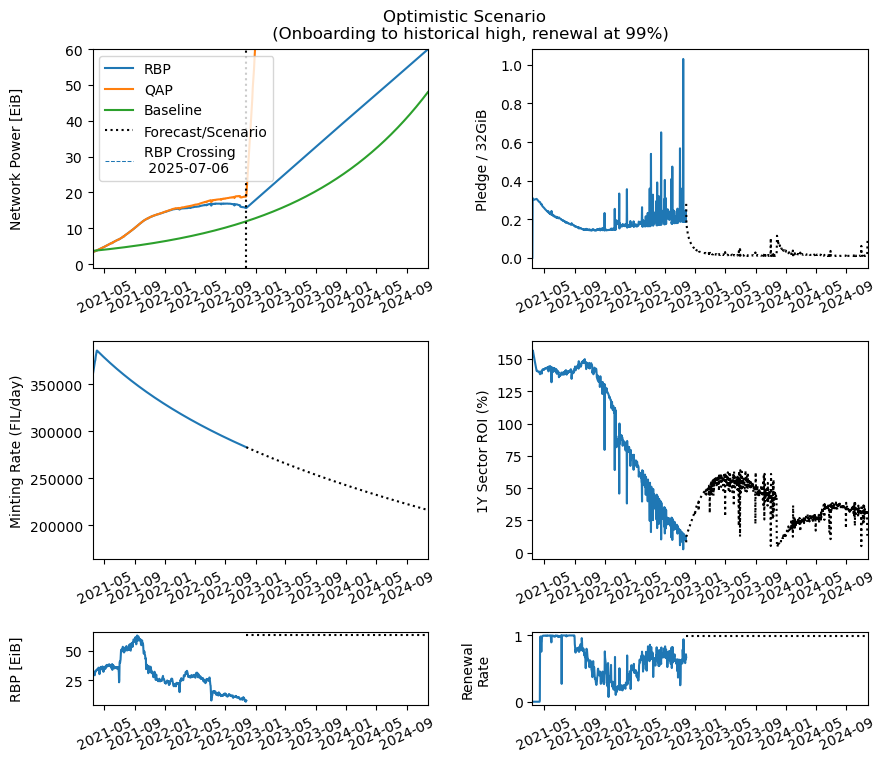

In [6]:
scenario_params = curated.forecast_optimistic_scenario(forecast_lenght)
compute_and_plot_blc(scenario_params['rb_onboard_power'], 
                     scenario_params['renewal_rate'], 
                     scenario_params['filplus_rate'],
                     "Optimistic Scenario \n (Onboarding to historical high, renewal at 99%)")

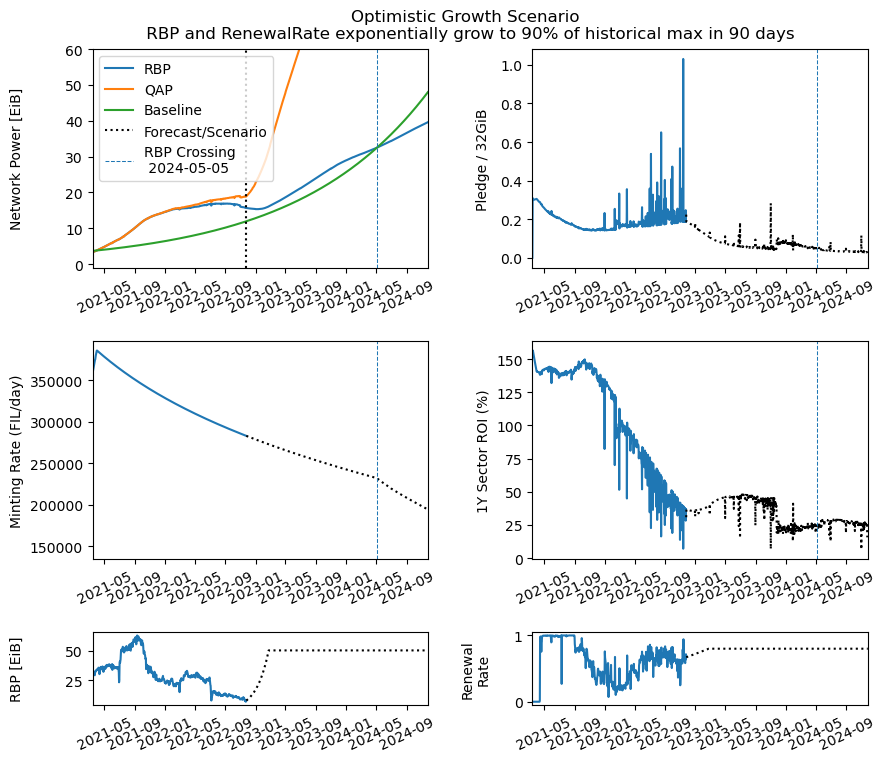

In [7]:
scenario_params = curated.forecast_optimistic_growth_scenario(forecast_lenght)
save_fp = os.path.join(os.environ['HOME'], 'Documents', 'hackmd', 'baseline_crossing', 'optimistic.png')
compute_and_plot_blc(scenario_params['rb_onboard_power'], 
                     scenario_params['renewal_rate'], 
                     scenario_params['filplus_rate'],
                     "Optimistic Growth Scenario \n RBP and RenewalRate exponentially grow to 90% of historical max in 90 days",
                     save_fp=save_fp)

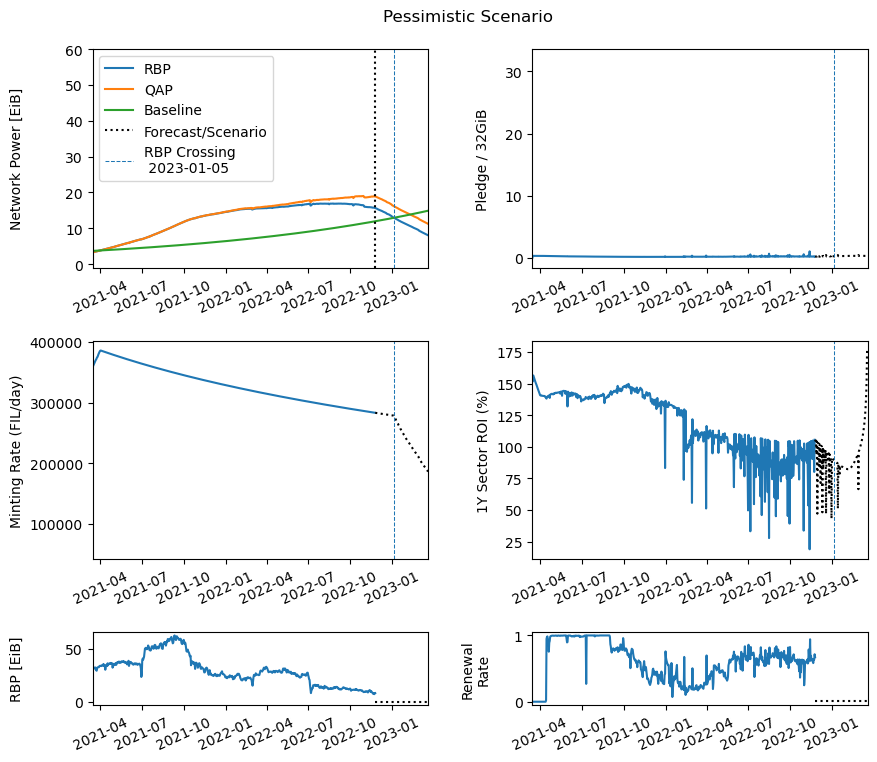

In [8]:
scenario_params = curated.forecast_pessimistic_scenario(forecast_lenght)
compute_and_plot_blc(scenario_params['rb_onboard_power'], 
                     scenario_params['renewal_rate'], 
                     scenario_params['filplus_rate'],
                     "Pessimistic Scenario")

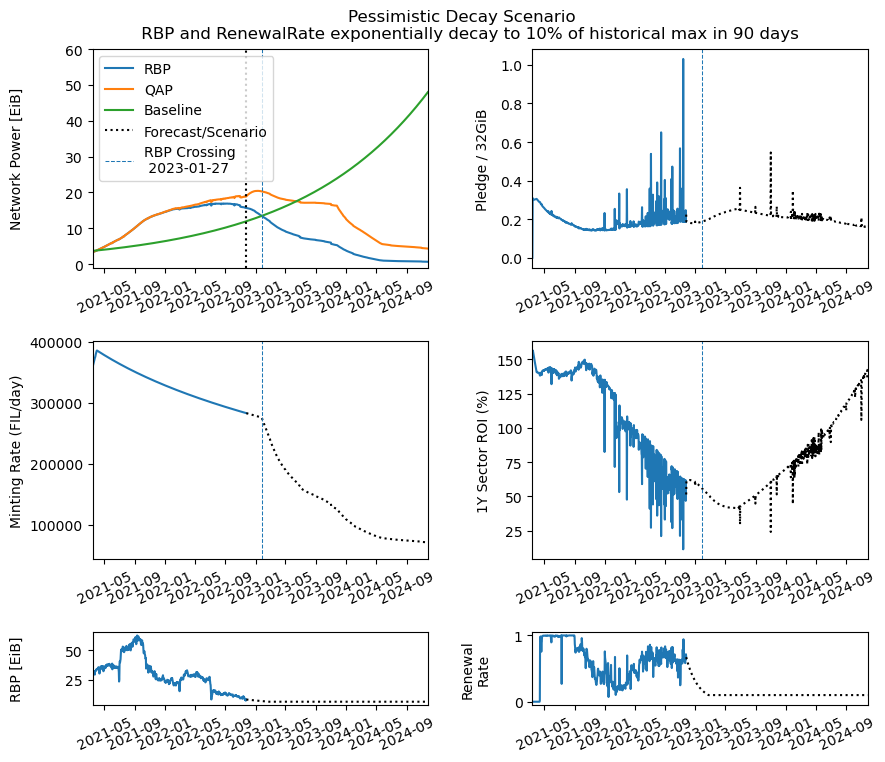

In [9]:
scenario_params = curated.forecast_pessimistic_decay_scenario(forecast_lenght)
save_fp = os.path.join(os.environ['HOME'], 'Documents', 'hackmd', 'baseline_crossing', 'pessimistic.png')
compute_and_plot_blc(scenario_params['rb_onboard_power'], 
                     scenario_params['renewal_rate'], 
                     scenario_params['filplus_rate'],
                     "Pessimistic Decay Scenario  \n RBP and RenewalRate exponentially decay to 10% of historical max in 90 days",
                     save_fp=save_fp)

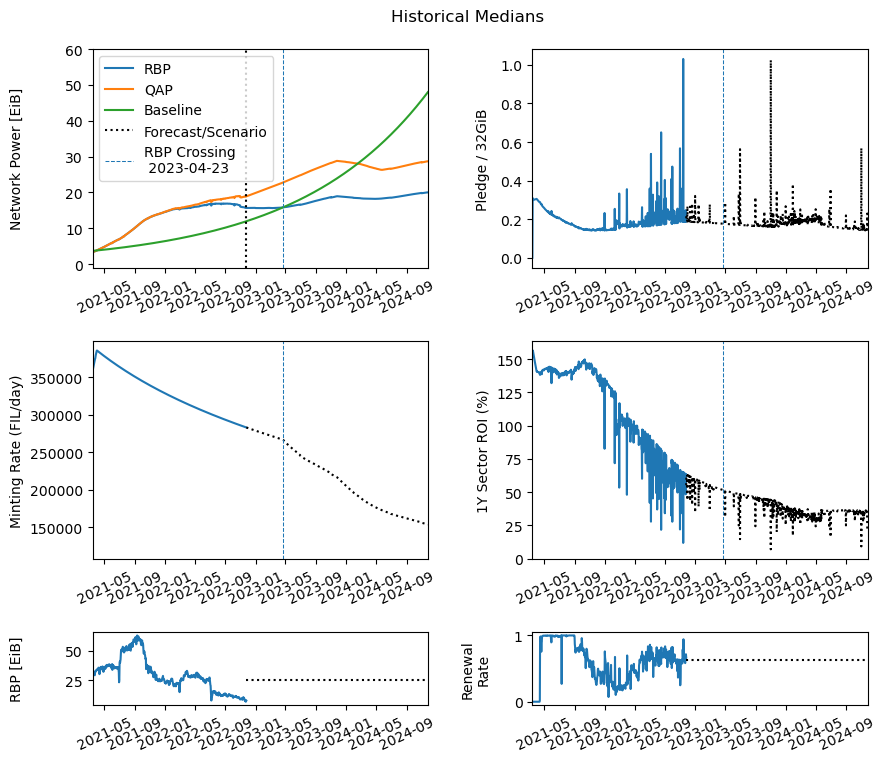

In [10]:
scenario_params = curated.forecast_historical_median_scenario(forecast_lenght)
compute_and_plot_blc(scenario_params['rb_onboard_power'], 
                     scenario_params['renewal_rate'], 
                     scenario_params['filplus_rate'],
                     "Historical Medians")

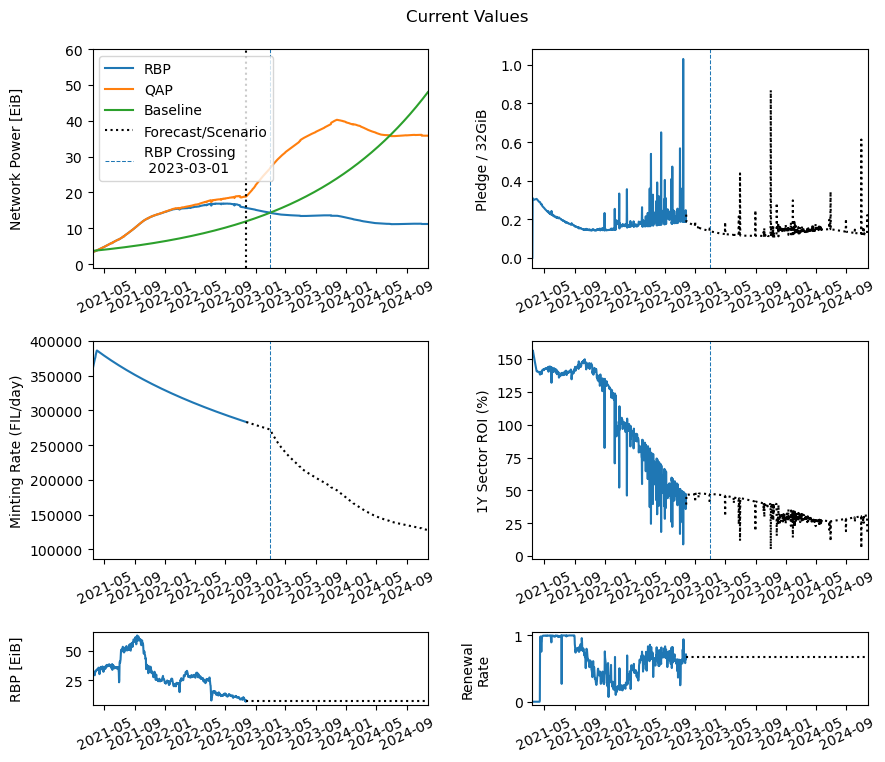

In [11]:
scenario_params = curated.forecast_current_value_scenario(forecast_lenght)
compute_and_plot_blc(scenario_params['rb_onboard_power'], 
                     scenario_params['renewal_rate'], 
                     scenario_params['filplus_rate'],
                     "Current Values")

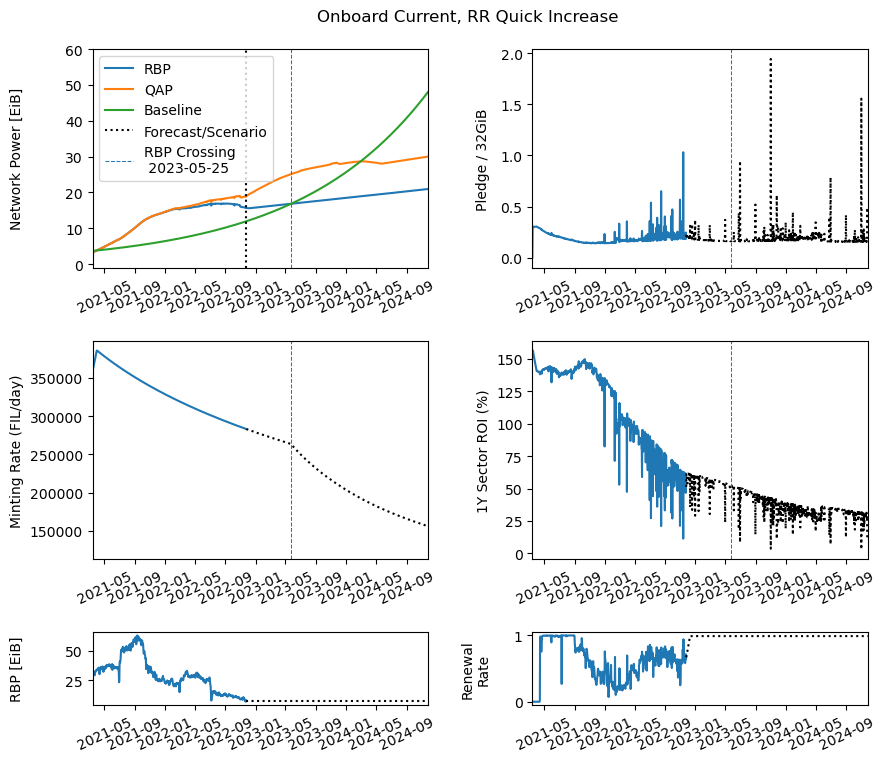

In [12]:
scenario_params = curated.forecast_onboard_current_rr_high_fpr_median_scenario(forecast_lenght)
compute_and_plot_blc(scenario_params['rb_onboard_power'], 
                     scenario_params['renewal_rate'], 
                     scenario_params['filplus_rate'],
                     "Onboard Current, RR Quick Increase")

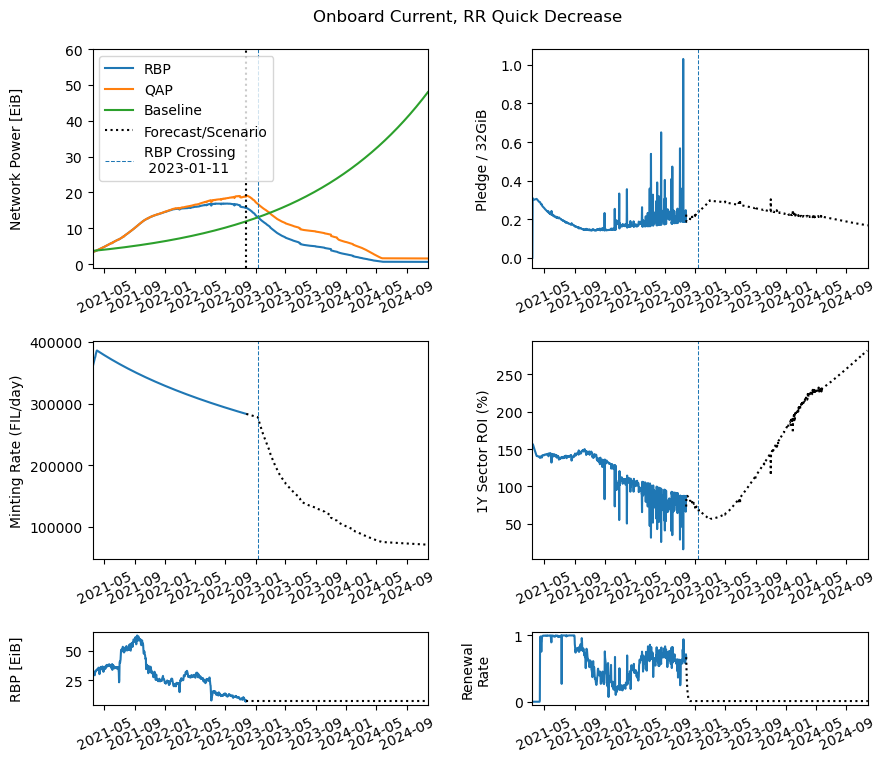

In [13]:
scenario_params = curated.forecast_onboard_current_rr_low_fpr_median_scenario(forecast_lenght)
compute_and_plot_blc(scenario_params['rb_onboard_power'], 
                     scenario_params['renewal_rate'], 
                     scenario_params['filplus_rate'],
                     "Onboard Current, RR Quick Decrease")

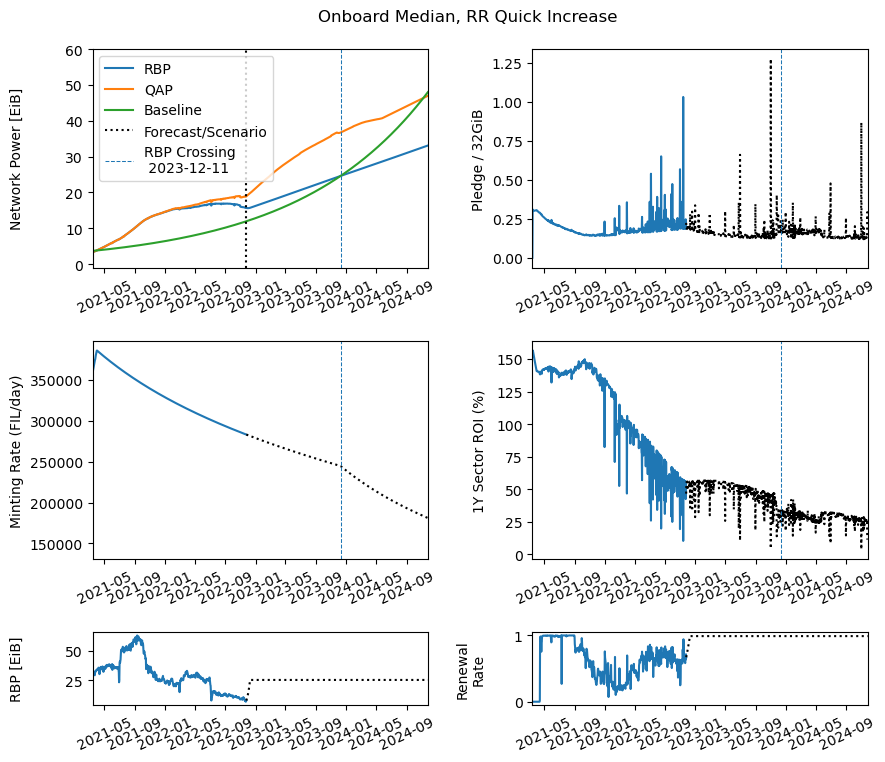

In [14]:
scenario_params = curated.forecast_onboard_median_rr_high_fpr_median_scenario(forecast_lenght)
compute_and_plot_blc(scenario_params['rb_onboard_power'], 
                     scenario_params['renewal_rate'], 
                     scenario_params['filplus_rate'],
                     "Onboard Median, RR Quick Increase")

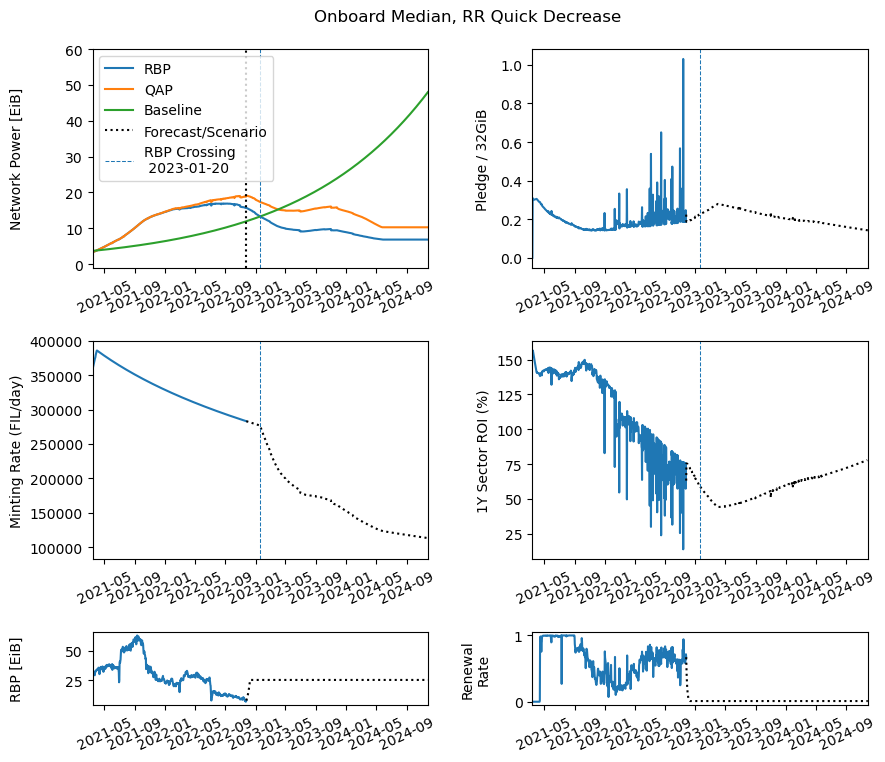

In [15]:
scenario_params = curated.forecast_onboard_median_rr_low_fpr_median_scenario(forecast_lenght)
compute_and_plot_blc(scenario_params['rb_onboard_power'], 
                     scenario_params['renewal_rate'], 
                     scenario_params['filplus_rate'],
                     "Onboard Median, RR Quick Decrease")

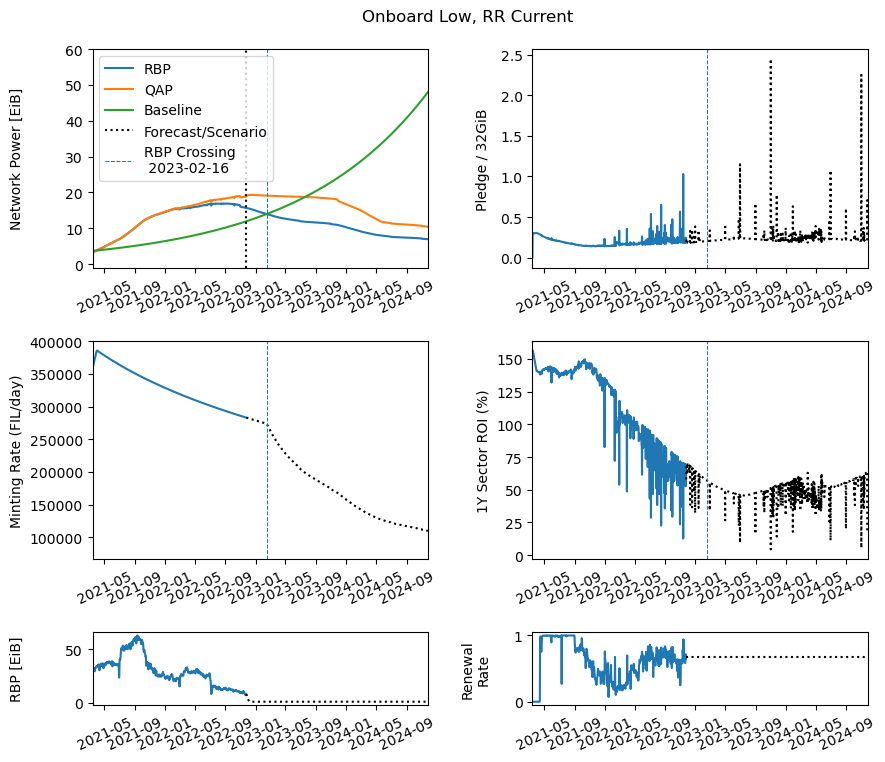

In [16]:
scenario_params = curated.forecast_onboard_low_rr_current_fpr_median_scenario(forecast_lenght)
compute_and_plot_blc(scenario_params['rb_onboard_power'], 
                     scenario_params['renewal_rate'], 
                     scenario_params['filplus_rate'],
                     "Onboard Low, RR Current")

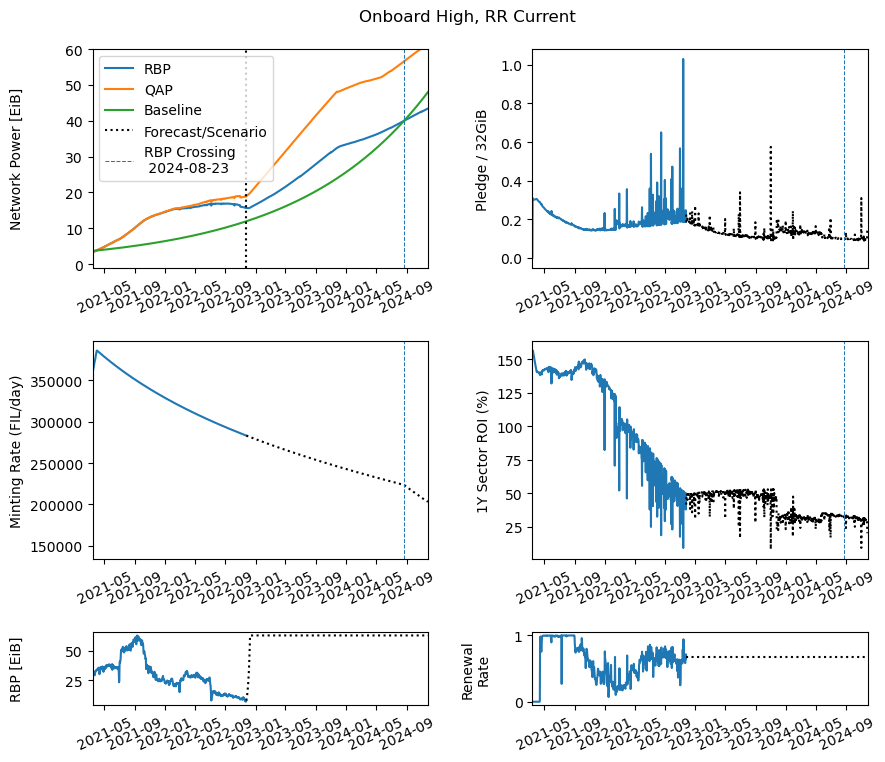

In [17]:
scenario_params = curated.forecast_onboard_high_rr_current_fpr_median_scenario(forecast_lenght)
compute_and_plot_blc(scenario_params['rb_onboard_power'], 
                     scenario_params['renewal_rate'], 
                     scenario_params['filplus_rate'],
                     "Onboard High, RR Current")

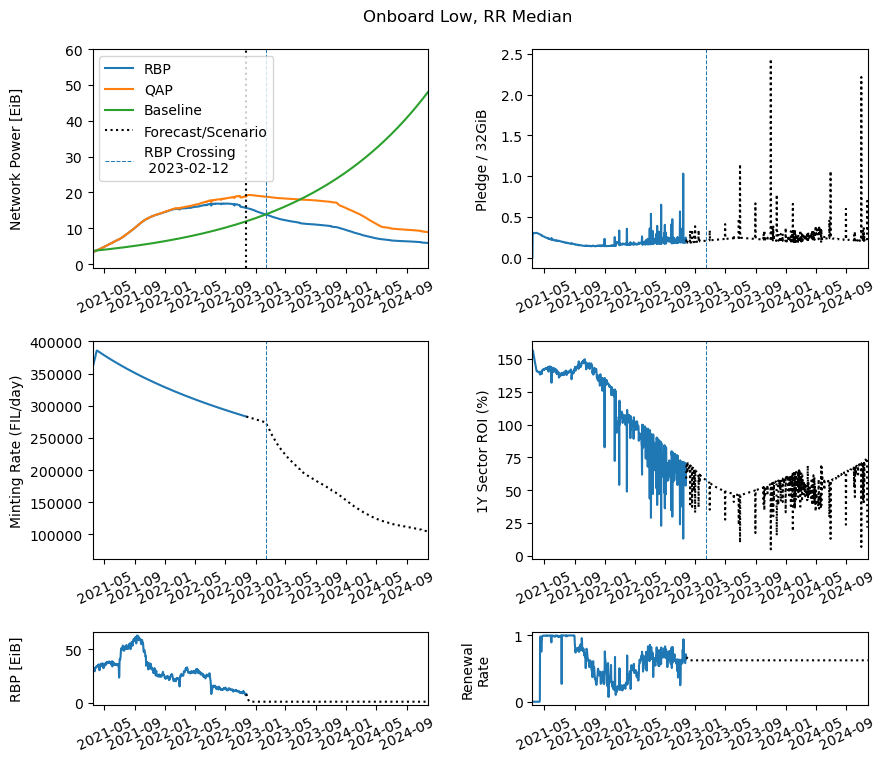

In [18]:
scenario_params = curated.forecast_onboard_low_rr_median_fpr_median_scenario(forecast_lenght)
compute_and_plot_blc(scenario_params['rb_onboard_power'], 
                     scenario_params['renewal_rate'], 
                     scenario_params['filplus_rate'],
                     "Onboard Low, RR Median")

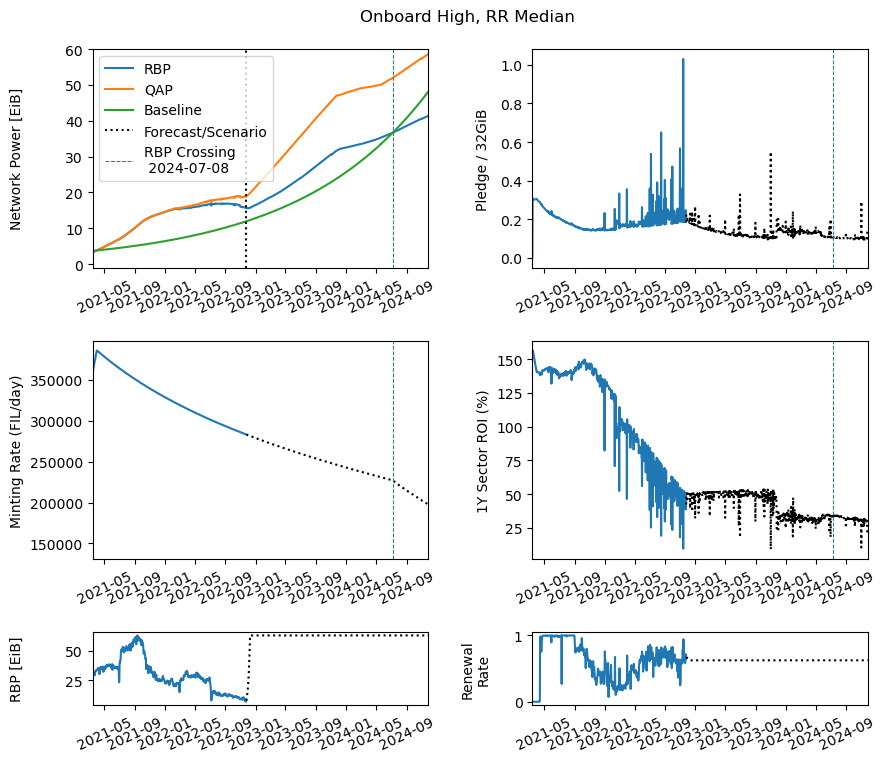

In [19]:
scenario_params = curated.forecast_onboard_high_rr_median_fpr_median_scenario(forecast_lenght)
compute_and_plot_blc(scenario_params['rb_onboard_power'], 
                     scenario_params['renewal_rate'], 
                     scenario_params['filplus_rate'],
                     "Onboard High, RR Median")